# 1. 
##  1.1) “images/greenscreen.jpg” dosyasında yer alan renkli görüntünün 3 ayrı kanalı için histogramını hesaplayıp analiz ediniz. 
##  1.2) Görüntünün içerisinde baskın olan renk için RGB kanallarında hangi yoğunluk değerinin oluştuğunu tespit ediniz. 
##  1.3) Bu yoğunluk değerlerini RGB kanallarında istediğiniz bir renk ile güncelleyerek görüntüdeki baskın rengin değişmesini sağlayınız.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

##  1.1) “images/greenscreen.jpg” dosyasında yer alan renkli görüntünün 3 ayrı kanalı için histogramını hesaplayıp analiz ediniz. 

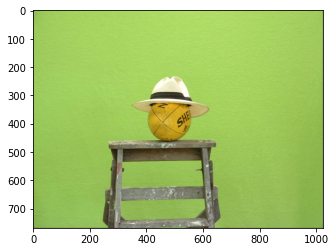

In [2]:
from utils import img_read
img = img_read('../images/greenscreen.jpg')

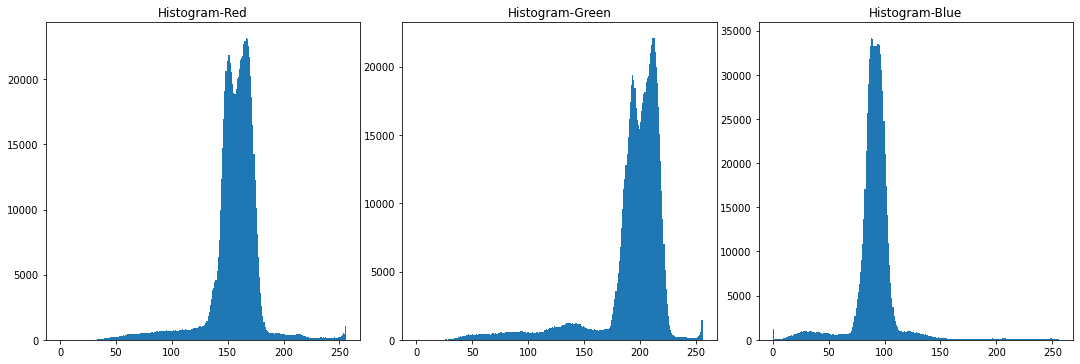

In [3]:
from utils import show_hist
show_hist(img, channel_order="RGB", cumulative=False, bins=256)

##  1.2) Görüntünün içerisinde baskın olan renk için RGB kanallarında hangi yoğunluk değerinin oluştuğunu tespit ediniz. 

### Method 1: Top frequency Color 

In [4]:
def unique_count_app(a):
    colors, count = np.unique(a.reshape(-1,a.shape[-1]), axis=0, return_counts=True)
    return colors[count.argmax()]
unique_count_app(img)

array([169, 214,  97], dtype=uint8)

### Method 2: Top K frequency colors

palette_percenteges: {'[150.6075313063013, 186.72387619831397, 86.10400309170511]': 0.46, '[94.09438428309367, 90.18154920410433, 59.41911750202114]': 0.06, '[169.09823619978567, 211.21649829947734, 99.41327118062665]': 0.48}


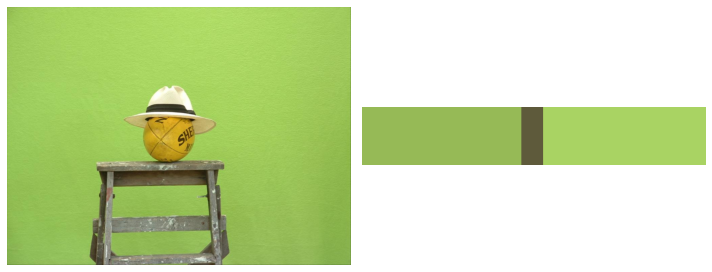

In [5]:
def palette(clusters):
    width=300
    palette = np.zeros((50, width, 3), np.uint8)
    steps = width/clusters.cluster_centers_.shape[0]
    for idx, centers in enumerate(clusters.cluster_centers_): 
        palette[:, int(idx*steps):(int((idx+1)*steps)), :] = centers
    return palette

from collections import Counter
def palette_perc(k_cluster):
    width = 300
    palette = np.zeros((50, width, 3), np.uint8)
    
    n_pixels = len(k_cluster.labels_)
    counter = Counter(k_cluster.labels_) # count how many pixels per cluster
    perc = {}
    for i in counter:
        perc[i] = np.round(counter[i]/n_pixels, 2)
    perc = dict(sorted(perc.items()))
    
    # For logging purposes
    #print(perc)
    #print(k_cluster.cluster_centers_)
    palette_percenteges = {k:v for k,v in zip([str(color.tolist()) for color in k_cluster.cluster_centers_], perc.values()) }
    print(f"palette_percenteges: {palette_percenteges}")
    
    step = 0
    for idx, centers in enumerate(k_cluster.cluster_centers_): 
        palette[:, step:int(step + perc[idx]*width+1), :] = centers
        step += int(perc[idx]*width+1)
        
    return palette_percenteges, palette

def show_img_compar(img_1, img_2):
    f, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img_1)
    ax[1].imshow(img_2)
    ax[0].axis("off")  # hide the axis
    ax[1].axis("off")
    f.tight_layout()
    #f.suptitle(title, fontsize=32)
    plt.show()


from sklearn.cluster import KMeans

clt = KMeans(n_clusters=3)
clt_1 = clt.fit(img.reshape(-1, 3))

palette_percenteges, color_palette = palette_perc(clt_1)
#color_palette = palette(clt_1)
show_img_compar(img, color_palette)

##  1.3) Bu yoğunluk değerlerini RGB kanallarında istediğiniz bir renk ile güncelleyerek görüntüdeki baskın rengin değişmesini sağlayınız.
### Chroma keying
### https://medium.com/fnplus/blue-or-green-screen-effect-with-open-cv-chroma-keying-94d4a6ab2743

In [8]:
def change_background(img, 
                      threshold=((0, 170, 0), (200, 255, 150)), 
                      new_background=(150, 255, 255), 
                      convert_rgb=False):
    
    ## Method 1: RGB filtering
    if convert_rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr 2 rgb
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.show()
    
    lower_th = np.array([threshold[0]])     # [R value, G value, B value]
    upper_th = np.array([threshold[1]]) 

    mask = cv2.inRange(img, lower_th, upper_th)

    # Method 2: HSV filtering
    #hsv = cv2.cvtColor(img_org, cv2.COLOR_BGR2HSV)
    ## mask of green (36,25,25) ~ (86, 255,255)
    #mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    #mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

    plt.imshow(mask, cmap='gray')
    plt.title('Mask')

    ## slice the green
    imask = mask>0
    green = np.zeros_like(img, np.uint8)
    green[imask] = img[imask]
    plt.imshow(green)
    plt.title('background')
    plt.show()


    masked_image = np.copy(img)
    masked_image[mask != 0] = [0, 0, 0]
    plt.imshow(masked_image)
    plt.title('masked_image')
    plt.show()
    
    if isinstance(new_background, str):
        background_image = cv2.imread(str)
        background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
    elif isinstance(new_background, tuple) or isinstance(new_background, list):
        background_image = np.zeros_like(img)
        background_image[:] = new_background
    else:
        background_image=new_background
    
    crop_background = background_image[0:img.shape[0], 0:img.shape[1]]
    crop_background[mask == 0] = [0, 0, 0]

    plt.imshow(crop_background)
    plt.title('crop_background')
    plt.show()

    final_image = crop_background + masked_image
    plt.imshow(final_image)
    plt.title('final_image')
    plt.show()
    
    return final_image

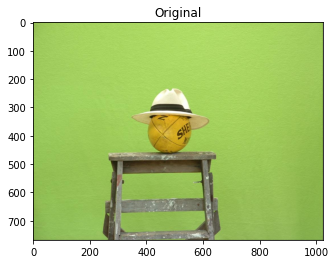

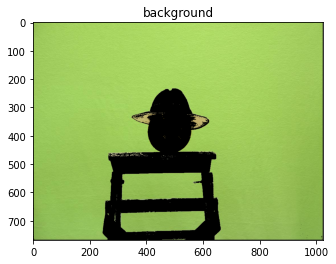

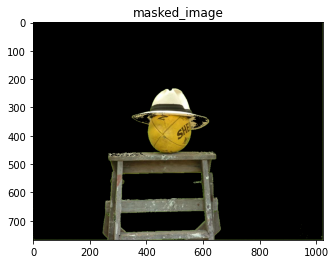

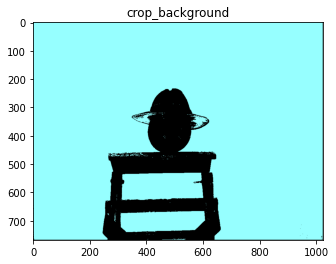

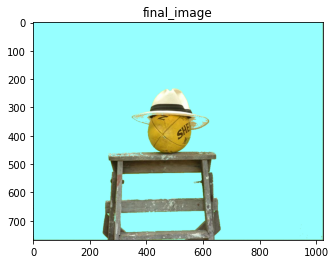

In [9]:
threshold = ((0, 170, 0), (200, 255, 150))
out = change_background(img=img, threshold=((0, 170, 0), (200, 255, 150)), new_background=(150, 255, 255))